# CWRU Bearing Fault Data - 1DCNN Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import os
import pickle

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-06-17 07:20:34.905873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750144835.105892      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750144835.164980      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def count_frames(signal_length, frame_length, hop_length):
    return max(1, 1 + (signal_length - frame_length) // hop_length)

In [3]:
def fragment_and_normalize(df, frame_size=1024, hop_size=512):
    fragments = []
    labels = []

    for idx, row in df.iterrows():
        signal = row['signal']
        label = row['label']

        for start in range(0, len(signal) - frame_size + 1, hop_size):
            frame = signal[start:start+frame_size]


            frame = (frame - np.mean(frame)) / np.std(frame)

            fragments.append(frame)
            labels.append(label)

    fragments = np.array(fragments)
    labels = np.array(labels)

    fragments = fragments[..., np.newaxis]

    return fragments, labels


In [4]:
def add_gaussian_noise(signal, noise_level=0.005):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

In [5]:
def add_masking_noise(signal, mask_fraction=0.1):
    signal = signal.copy()
    n_mask = int(mask_fraction * signal.shape[0])
    mask_indices = np.random.choice(signal.shape[0], n_mask, replace=False)
    signal[mask_indices] = 0
    return signal

In [6]:
def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift)

In [7]:
def amplitude_shift(signal, shift_range=0.1):
    shift = np.random.uniform(1 - shift_range, 1 + shift_range)
    return signal * shift

In [8]:
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, shuffle=True, augment=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
      batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
      X_batch = self.X[batch_indexes]
      y_batch = self.y[batch_indexes]

      if self.augment:
        X_batch = np.array([self.augment_sample(x) for x in X_batch])

      return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def augment_sample(self, signal):
        if np.random.rand() < 0.5:
            signal = add_gaussian_noise(signal)
        if np.random.rand() < 0.5:
            signal = add_masking_noise(signal)
        if np.random.rand() < 0.5:
            signal = time_shift(signal)
        if np.random.rand() < 0.5:
            signal = amplitude_shift(signal)
        return signal

In [ ]:
with open('48kdrive-end_normalbaseline_loadsplit_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [10]:
SAMPLE_RATE = 48000
FRAME_SIZE = 1024
HOP_SIZE = 512

INPUT_SHAPE = (FRAME_SIZE, 1)
NUM_CLASSES = 14
BATCH_SIZE = 64

## Preprocessing and exploratory analysis of data for 1DCNN

### Basic data characteristics

In [11]:
data.head()

,signal,label,load
0,"[0.05319692307692307, 0.08866153846153846, 0.0...",Normal,0
1,"[-0.111192, -0.08302892307692307, -0.042348923...",B007,0
2,"[0.03984553846153846, 0.0897046153846154, 0.13...",B014,0
3,"[0.17152399999999998, 0.326772, 0.491618666666...",B021,0
4,"[0.051749333333333335, 0.05592266666666667, 0....",OR021@12,0


In [12]:
print(f'Liczba kombinacji klas uszkodzeń i loadów: {len(data)}')

Liczba kombinacji klas uszkodzeń i loadów: 56


In [13]:
print(f'Liczba unikalnych klass: {len(data["label"].unique())}')
print(f'Unikalne klasy: {data["label"].unique()}')

Liczba unikalnych klass: 14
Unikalne klasy: ['Normal' 'B007' 'B014' 'B021' 'OR021@12' 'OR007@12' 'OR021@3' 'OR007@3'
 'IR007' 'IR014' 'IR021' 'OR014@6' 'OR021@6' 'OR007@6']


In [14]:
data['signal_length'] = data['signal'].apply(len)
print(data.groupby('label')['signal_length'].agg(['count', 'mean', 'std', 'min', 'max']))

data.drop('signal_length', axis=1, inplace=True)

          count       mean            std     min     max
label                                                    
B007          4  426868.00  121421.490852  244739  488545
B014          4  427389.50  118829.943649  249146  487384
B021          4  426232.50  121529.974227  243938  487384
IR007         4  425362.00  120949.643436  243938  486224
IR014         4  381485.00  211804.888938   63788  489125
IR021         4  428073.50  122526.619030  244339  491446
Normal        4  424346.75  120275.296949  243938  485643
OR007@12      4  395129.25  176774.981564  129969  484483
OR007@3       4  395383.00  180521.288903  124602  486224
OR007@6       4  426277.50  121827.560575  243538  487964
OR014@6       4  426243.00  120746.798624  245140  488545
OR021@12      4  397450.25  177934.376732  130549  486804
OR021@3       4  397558.75  179276.561521  128663  489705
OR021@6       4  428139.00  121199.235732  246342  489125


### Data framing and summary

In [15]:
data['num_frames'] = data['signal'].apply(lambda x: count_frames(len(x), FRAME_SIZE, HOP_SIZE))

frame_stats = data.groupby('label')['num_frames'].agg(['count', 'mean', 'min', 'max', 'sum']).reset_index()
frame_stats.rename(columns={'sum': 'total_frames'}, inplace=True)

print(frame_stats)

data.drop('num_frames', axis=1, inplace=True)

       label  count    mean  min  max  total_frames
0       B007      4  832.25  477  953          3329
1       B014      4  833.00  485  950          3332
2       B021      4  830.75  475  950          3323
3      IR007      4  829.25  475  948          3317
4      IR014      4  743.75  123  954          2975
5      IR021      4  834.50  476  958          3338
6     Normal      4  827.50  475  947          3310
7   OR007@12      4  770.00  252  945          3080
8    OR007@3      4  770.75  242  948          3083
9    OR007@6      4  831.00  474  952          3324
10   OR014@6      4  831.00  477  953          3324
11  OR021@12      4  774.50  253  949          3098
12   OR021@3      4  775.00  250  955          3100
13   OR021@6      4  835.00  480  954          3340


In [16]:
X, y = fragment_and_normalize(data, frame_size=FRAME_SIZE, hop_size=HOP_SIZE)

print(f"Liczba fragmentów (ramek): {X.shape[0]}")
print(f"Kształt fragmentów (ilość, długość, kanały): {X.shape}")

Liczba fragmentów (ramek): 45273
Kształt fragmentów (ilość, długość, kanały): (45273, 1024, 1)


In [17]:
if X.dtype != np.float32:
    X = X.astype(np.float32)
    print('Przekonwertowano X na float32')

Przekonwertowano X na float32


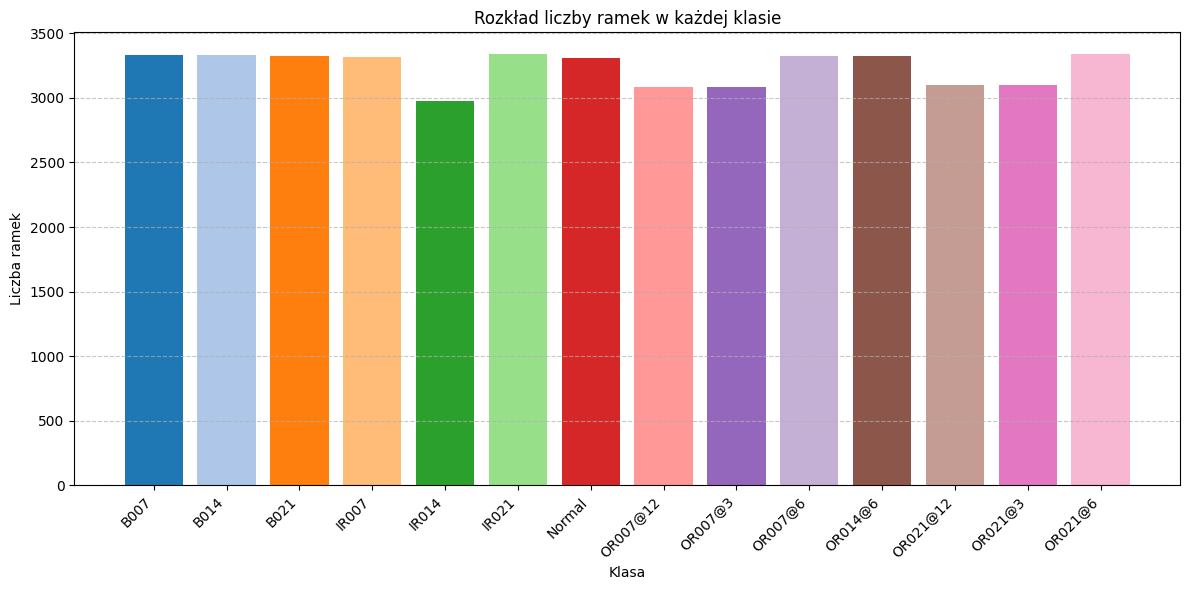

In [18]:
class_counts = {label: count for label, count in zip(np.unique(y), [len(y[y == label]) for label in np.unique(y)])}
classes = list(class_counts.keys())
counts = list(class_counts.values())

colors = plt.cm.tab20.colors

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color=colors[:len(classes)])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Klasa')
plt.ylabel('Liczba ramek')
plt.title('Rozkład liczby ramek w każdej klasie')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Class label preprocessing

In [19]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f'Zakodowane klasy: {np.unique(y_encoded)}')

Zakodowane klasy: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [20]:
print(f'Kształt y przed kodowaniem: {y.shape}')
print(f'Kształt y po kodowaniu: {y_encoded.shape}')

Kształt y przed kodowaniem: (45273,)
Kształt y po kodowaniu: (45273,)


In [21]:
y_onehot = to_categorical(y_encoded)
print(f'Kształt y one-hot: {y_onehot.shape}')

Kształt y one-hot: (45273, 14)


In [22]:
y_labels = np.argmax(y_onehot, axis=1)
print(f"Kształt y_labels: {y_labels.shape}")

Kształt y_labels: (45273,)


### Train/Validation/Test split and Data Generators

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2025, stratify=y_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} ramek")
print(f"Validation: {X_val.shape[0]} ramek")
print(f"Test: {X_test.shape[0]} ramek")

Train: 31691 ramek
Validation: 6791 ramek
Test: 6791 ramek


In [24]:
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

y_train_onehot = to_categorical(y_train_enc)
y_val_onehot = to_categorical(y_val_enc)
y_test_onehot = to_categorical(y_test_enc)

In [25]:
train_gen = DataGenerator(X_train, y_train_onehot, batch_size=BATCH_SIZE, augment=True)
val_gen = DataGenerator(X_val, y_val_onehot, batch_size=BATCH_SIZE, augment=False)
test_gen = DataGenerator(X_test, y_test_onehot, batch_size=BATCH_SIZE, augment=False, shuffle=False)

## 1DCNN

### Model architecture and compilation

In [26]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=5, activation='relu',))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750144852.333849      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [27]:
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1020, 16)            │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1020, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 510, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 506, 32)             │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 506, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 253, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         518,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521,998 (1.99 MB)

 Trainable params: 521,902 (1.99 MB)

 Non-trainable params: 96 (384.00 B)

### Training the model with early stopping and LR scheduling

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_1dcnn.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [30]:
start_time = time.time()

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=60,
                    callbacks=[early_stop, checkpoint, reduce_lr])

end_time = time.time()
training_time = end_time - start_time
print(f"Czas treningu: {training_time:.2f} sekund")

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1750144856.647820     100 service.cc:148] XLA service 0x79b1940028f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750144856.648754     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750144856.990052     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/496 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0979 - loss: 3.3427

I0000 00:00:1750144859.574152     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


496/496 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.2991 - loss: 2.2088 - val_accuracy: 0.6403 - val_loss: 1.0337 - learning_rate: 2.0000e-04
Epoch 2/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6299 - loss: 1.0512 - val_accuracy: 0.7987 - val_loss: 0.5800 - learning_rate: 2.0000e-04
Epoch 3/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7303 - loss: 0.7581 - val_accuracy: 0.8420 - val_loss: 0.4514 - learning_rate: 2.0000e-04
Epoch 4/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7794 - loss: 0.6141 - val_accuracy: 0.8682 - val_loss: 0.3715 - learning_rate: 2.0000e-04
Epoch 5/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8040 - loss: 0.5269 - val_accuracy: 0.8848 - val_loss: 0.3321 - learning_rate: 2.0000e-04
Epoch 6/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8349 - loss: 0.4542 - val_accuracy: 0.8949 - val_loss: 0.2923 - learning_rate: 2.0000e-04
Epoch 7/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8

### Evaluating model performance (accuracy, loss, confusion matrix, classification report, learning curves)

In [31]:
unique_classes = ['B007', 'B014', 'B021', 'IR007', 'IR014', 'IR021', 'Normal',
                  'OR007@12', 'OR007@3', 'OR007@6', 'OR014@6', 'OR021@12', 'OR021@3', 'OR021@6']

test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

Test Accuracy: 0.9620
Test Loss: 0.1039
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


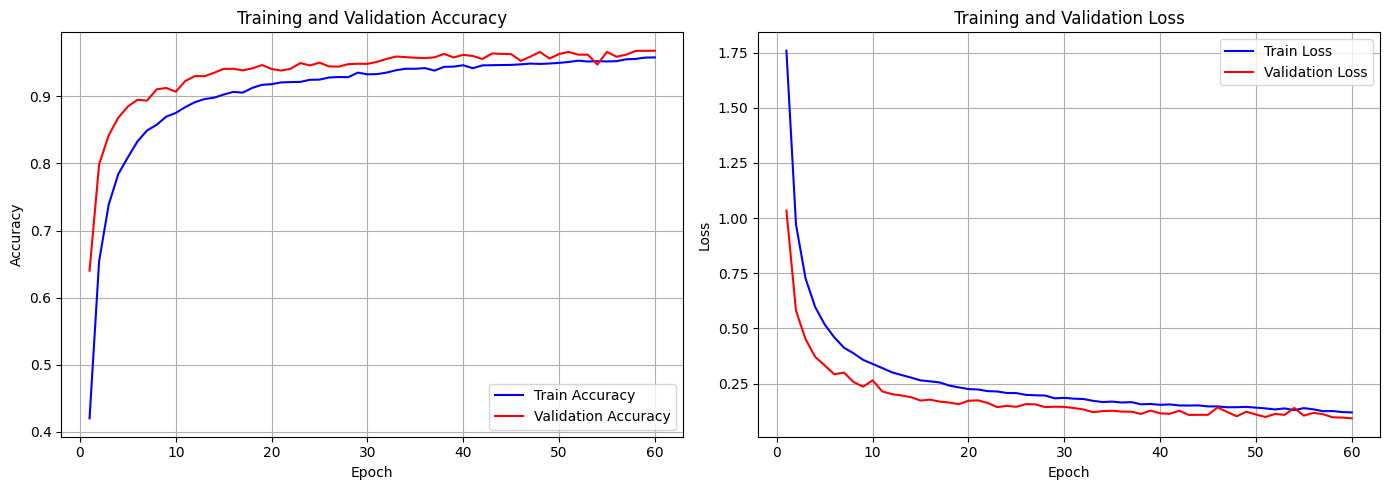

In [39]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

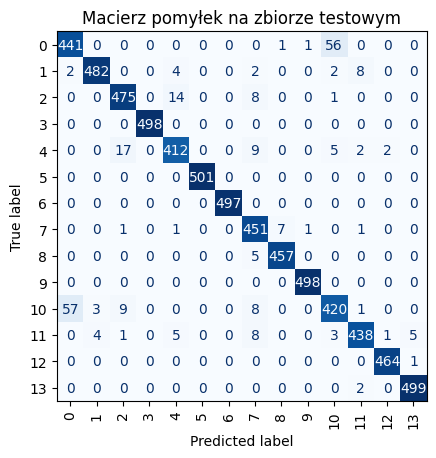

In [32]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', colorbar=False, xticks_rotation=90)
plt.title("Macierz pomyłek na zbiorze testowym")
plt.show()

In [33]:
# Predykcja prawdopodobieństw na zbiorze testowym
y_pred_probs = model.predict(test_gen, verbose=1)

# Zamiana prawdopodobieństw na klasy (indeksy)
y_pred = np.argmax(y_pred_probs, axis=1)

# Prawdziwe klasy (indeksy) z one-hot kodowania
y_true = np.argmax(y_test_onehot, axis=1)

# Raport klasyfikacji
print(classification_report(y_true, y_pred, target_names=unique_classes))


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

        B007       0.88      0.88      0.88       499
        B014       0.99      0.96      0.97       500
        B021       0.94      0.95      0.95       498
       IR007       1.00      1.00      1.00       498
       IR014       0.94      0.92      0.93       447
       IR021       1.00      1.00      1.00       501
      Normal       1.00      1.00      1.00       497
    OR007@12       0.92      0.98      0.95       462
     OR007@3       0.98      0.99      0.99       462
     OR007@6       1.00      1.00      1.00       498
     OR014@6       0.86      0.84      0.85       498
    OR021@12       0.97      0.94      0.96       465
     OR021@3       0.99      1.00      1.00       465
     OR021@6       0.99      1.00      0.99       501

    accuracy                           0.96      6791
   macro avg       0.96      0.96      0.96      6791
weighted avg       0.96      0.96      

In [36]:
model.save('best_1dcnn_model_final_version.h5')